In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("using", device)

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed(777)

c:\Users\ParkMinSu\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using cuda


In [3]:
batch_size = 256
noise_dim = 100
cont_dim = 4
dist_dim = 10
c_weight = 0.5

epoch = 500

test_len = 10
test_num = 50

lr_G = 0.0002
lr_D = 0.0002
k = 1

In [4]:
mnist_train = torchvision.datasets.MNIST(
    root = '../MNIST_data',
    train = True, 
    transform = torchvision.transforms.ToTensor(), 
    download = True
)
"""
mnist_test = torchvision.datasets.MNIST(
    root = '../MNIST_data', 
    train = False, 
    transform = torchvision.transforms.ToTensor(), 
    download = True
)
"""

"\nmnist_test = torchvision.datasets.MNIST(\n    root = '../MNIST_data', \n    train = False, \n    transform = torchvision.transforms.ToTensor(), \n    download = True\n)\n"

In [5]:
data_loader = torch.utils.data.DataLoader(
    dataset = mnist_train,
    shuffle = True,
    batch_size = batch_size,
    drop_last = True,
)

In [6]:
class discriminator(torch.nn.Module): # 28x28 size inputs -> true/false(classification)
    def __init__(self, noisedim) -> None:
        super().__init__()
        self.noisedim = noisedim
        self.act = torch.nn.LeakyReLU(0.2)
        self.conv1 = torch.nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.conv2 = torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(256)
        self.conv4 = torch.nn.Conv2d(256, 1 + noisedim, 4, 1, 0, bias=False)
        self.sig = torch.nn.Sigmoid()
        
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.act(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.act(out)

        out = self.conv4(out)
        out = self.sig(out)
  
        out = out.view(-1, 1 + self.noisedim)
        return out


In [7]:
class generator(torch.nn.Module): # 28x28 size inputs -> true/false(classification)
    def __init__(self, noisedim) -> None:
        super().__init__()
        self.noisedim = noisedim
        
        self.act = torch.nn.ReLU()
        self.conv1 = torch.nn.ConvTranspose2d(noisedim, 256, 4, 1, 0, bias=False)
        self.batchnorm1 = torch.nn.BatchNorm2d(256)
        self.conv2 = torch.nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)
        self.Tanh = torch.nn.Tanh()
        
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.act(out)

        out = self.conv4(out)
        out = self.Tanh(out)

        return out


In [8]:
def generate_cont(noisenum, contdim):
    return torch.randn(noisenum, contdim, 1, 1, device=device) + 0.5

In [9]:
def generate_dist_vector(noisenum, distdim):
    return torch.randint(0, distdim, size = (noisenum,), device=device)

In [10]:
def generate_dist(dist_np, distdim):
    return torch.nn.functional.one_hot(dist_np, num_classes = distdim).to(device).float().view(-1, distdim, 1, 1)

In [11]:
def generate_noise(noisenum, noisedim):
    return torch.randn(noisenum, noisedim, 1, 1, device=device)

In [12]:
def generate_labels(labelnum):
    return torch.zeros(labelnum, device=device), torch.ones(labelnum, device=device)

In [13]:
G = generator(noise_dim + cont_dim + dist_dim).to(device) #generator
D = discriminator(cont_dim + dist_dim).to(device) #discriminator
criterion = torch.nn.BCELoss()
crit_dist = torch.nn.CrossEntropyLoss()
G_optim = torch.optim.Adam(G.parameters(), lr = lr_G)
D_optim = torch.optim.Adam(D.parameters(), lr = lr_D)

cont_noise = generate_cont(test_len, cont_dim)
dist_noise = generate_dist(torch.arange(test_len), dist_dim)
noise_for_print = torch.cat([cont_noise, dist_noise, generate_noise(test_len, noise_dim)], dim=1)

fake_labels, real_labels = generate_labels(batch_size)
print_per = epoch / test_num
idx = 1
real_images_arr = []

for i, (image, label) in enumerate(data_loader):
    real_images_arr.append(image.to(device).view(-1, 1, 28, 28))

KeyboardInterrupt: 

EPOCH : 1 GLOSS: 8.810153007507324 DLOSS: 1.6406805515289307


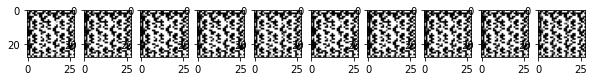

EPOCH : 2 GLOSS: 9.538804054260254 DLOSS: 1.6699038743972778
EPOCH : 3 GLOSS: 9.67018985748291 DLOSS: 1.6406488418579102
EPOCH : 4 GLOSS: 9.272150993347168 DLOSS: 1.4397242069244385
EPOCH : 5 GLOSS: 9.403759002685547 DLOSS: 1.3976593017578125
EPOCH : 6 GLOSS: 10.441764831542969 DLOSS: 1.3949774503707886
EPOCH : 7 GLOSS: 8.486967086791992 DLOSS: 1.3781743049621582
EPOCH : 8 GLOSS: 9.650625228881836 DLOSS: 1.3436119556427002
EPOCH : 9 GLOSS: 8.822686195373535 DLOSS: 1.3139243125915527
EPOCH : 10 GLOSS: 9.112249374389648 DLOSS: 1.2984585762023926
EPOCH : 11 GLOSS: 9.686607360839844 DLOSS: 1.431066870689392


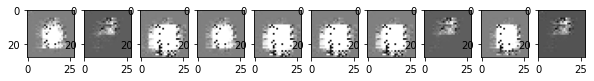

EPOCH : 12 GLOSS: 10.729921340942383 DLOSS: 1.427000641822815
EPOCH : 13 GLOSS: 9.586217880249023 DLOSS: 1.441566824913025
EPOCH : 14 GLOSS: 10.441794395446777 DLOSS: 1.4682763814926147
EPOCH : 15 GLOSS: 9.38892650604248 DLOSS: 1.4447259902954102
EPOCH : 16 GLOSS: 7.7224836349487305 DLOSS: 1.5475938320159912
EPOCH : 17 GLOSS: 9.448925018310547 DLOSS: 1.5446254014968872
EPOCH : 18 GLOSS: 12.224441528320312 DLOSS: 1.4095304012298584
EPOCH : 19 GLOSS: 21.876361846923828 DLOSS: 1.4171302318572998
EPOCH : 20 GLOSS: 12.105612754821777 DLOSS: 1.4725584983825684
EPOCH : 21 GLOSS: 9.467109680175781 DLOSS: 1.4347002506256104


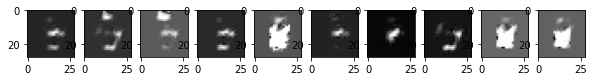

EPOCH : 22 GLOSS: 9.931981086730957 DLOSS: 1.4996894598007202
EPOCH : 23 GLOSS: 11.106793403625488 DLOSS: 1.5285555124282837
EPOCH : 24 GLOSS: 9.337851524353027 DLOSS: 1.4549931287765503
EPOCH : 25 GLOSS: 14.086533546447754 DLOSS: 1.444013237953186
EPOCH : 26 GLOSS: 9.934489250183105 DLOSS: 1.5184834003448486
EPOCH : 27 GLOSS: 8.33917236328125 DLOSS: 1.5109302997589111
EPOCH : 28 GLOSS: 9.949012756347656 DLOSS: 1.443316102027893
EPOCH : 29 GLOSS: 10.265054702758789 DLOSS: 1.5229687690734863
EPOCH : 30 GLOSS: 8.442748069763184 DLOSS: 1.480454444885254
EPOCH : 31 GLOSS: 8.915933609008789 DLOSS: 1.4723780155181885


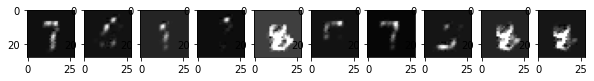

EPOCH : 32 GLOSS: 10.808420181274414 DLOSS: 1.4315822124481201
EPOCH : 33 GLOSS: 7.960310935974121 DLOSS: 1.4668679237365723
EPOCH : 34 GLOSS: 11.514613151550293 DLOSS: 1.4004875421524048
EPOCH : 35 GLOSS: 10.377756118774414 DLOSS: 1.5706464052200317
EPOCH : 36 GLOSS: 12.659820556640625 DLOSS: 1.4493800401687622
EPOCH : 37 GLOSS: 9.026347160339355 DLOSS: 1.5433274507522583
EPOCH : 38 GLOSS: 9.889559745788574 DLOSS: 1.4929581880569458
EPOCH : 39 GLOSS: 9.058146476745605 DLOSS: 1.4865578413009644
EPOCH : 40 GLOSS: 8.714508056640625 DLOSS: 1.5268932580947876
EPOCH : 41 GLOSS: 10.15247917175293 DLOSS: 1.5554143190383911


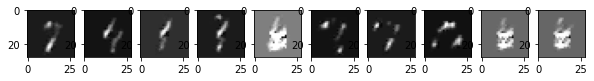

EPOCH : 42 GLOSS: 13.555859565734863 DLOSS: 1.4682388305664062
EPOCH : 43 GLOSS: 7.697825908660889 DLOSS: 1.5015428066253662
EPOCH : 44 GLOSS: 8.082109451293945 DLOSS: 1.4484779834747314
EPOCH : 45 GLOSS: 9.29010009765625 DLOSS: 1.477198600769043
EPOCH : 46 GLOSS: 7.793885231018066 DLOSS: 1.4767396450042725
EPOCH : 47 GLOSS: 6.913437843322754 DLOSS: 1.476074457168579
EPOCH : 48 GLOSS: 10.205543518066406 DLOSS: 1.4394938945770264
EPOCH : 49 GLOSS: 8.512598991394043 DLOSS: 1.441039800643921
EPOCH : 50 GLOSS: 8.931794166564941 DLOSS: 1.4109082221984863
EPOCH : 51 GLOSS: 8.837540626525879 DLOSS: 1.4767842292785645


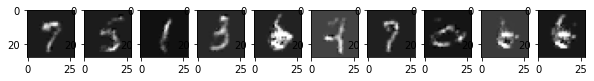

EPOCH : 52 GLOSS: 6.434009552001953 DLOSS: 1.4826091527938843
EPOCH : 53 GLOSS: 11.145934104919434 DLOSS: 1.4471228122711182
EPOCH : 54 GLOSS: 9.7406587600708 DLOSS: 1.4518771171569824
EPOCH : 55 GLOSS: 8.22744083404541 DLOSS: 1.5260722637176514
EPOCH : 56 GLOSS: 6.215877532958984 DLOSS: 1.4667292833328247
EPOCH : 57 GLOSS: 7.06768798828125 DLOSS: 1.4224594831466675
EPOCH : 58 GLOSS: 6.1694440841674805 DLOSS: 1.404116153717041
EPOCH : 59 GLOSS: 6.446742534637451 DLOSS: 1.410612940788269
EPOCH : 60 GLOSS: 5.958621978759766 DLOSS: 1.421533226966858
EPOCH : 61 GLOSS: 6.727272033691406 DLOSS: 1.4317045211791992


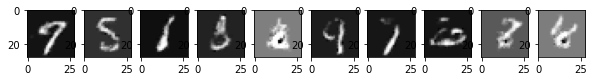

EPOCH : 62 GLOSS: 10.41562271118164 DLOSS: 1.4022269248962402
EPOCH : 63 GLOSS: 5.964659690856934 DLOSS: 1.40504789352417
EPOCH : 64 GLOSS: 8.995881080627441 DLOSS: 1.4359214305877686
EPOCH : 65 GLOSS: 6.740319728851318 DLOSS: 1.4094367027282715
EPOCH : 66 GLOSS: 7.508810043334961 DLOSS: 1.4408429861068726
EPOCH : 67 GLOSS: 6.881352424621582 DLOSS: 1.3813934326171875
EPOCH : 68 GLOSS: 7.26832389831543 DLOSS: 1.3957877159118652
EPOCH : 69 GLOSS: 5.198296546936035 DLOSS: 1.5291742086410522
EPOCH : 70 GLOSS: 5.124026298522949 DLOSS: 1.4354913234710693
EPOCH : 71 GLOSS: 9.011760711669922 DLOSS: 1.3903974294662476


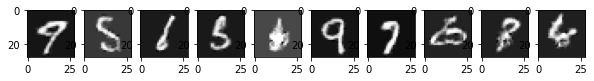

EPOCH : 72 GLOSS: 5.892740249633789 DLOSS: 1.3469665050506592
EPOCH : 73 GLOSS: 5.598987579345703 DLOSS: 1.400179147720337
EPOCH : 74 GLOSS: 5.075611114501953 DLOSS: 1.4365925788879395
EPOCH : 75 GLOSS: 6.536481857299805 DLOSS: 1.4045823812484741
EPOCH : 76 GLOSS: 5.711802959442139 DLOSS: 1.3446574211120605
EPOCH : 77 GLOSS: 7.073609828948975 DLOSS: 1.3457603454589844
EPOCH : 78 GLOSS: 6.725523948669434 DLOSS: 1.4154185056686401
EPOCH : 79 GLOSS: 6.282712459564209 DLOSS: 1.362833023071289
EPOCH : 80 GLOSS: 6.981905937194824 DLOSS: 1.3822839260101318
EPOCH : 81 GLOSS: 6.319647312164307 DLOSS: 1.3643276691436768


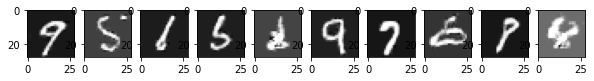

EPOCH : 82 GLOSS: 13.453726768493652 DLOSS: 1.4981096982955933
EPOCH : 83 GLOSS: 5.9937286376953125 DLOSS: 1.3741939067840576
EPOCH : 84 GLOSS: 5.939316272735596 DLOSS: 1.3725192546844482
EPOCH : 85 GLOSS: 5.091363430023193 DLOSS: 1.4127130508422852
EPOCH : 86 GLOSS: 6.081820487976074 DLOSS: 1.436028242111206
EPOCH : 87 GLOSS: 7.564494609832764 DLOSS: 1.3902668952941895
EPOCH : 88 GLOSS: 5.443772315979004 DLOSS: 1.3336423635482788
EPOCH : 89 GLOSS: 6.837822437286377 DLOSS: 1.3485355377197266
EPOCH : 90 GLOSS: 4.252762317657471 DLOSS: 1.4465540647506714
EPOCH : 91 GLOSS: 6.877416610717773 DLOSS: 1.3440146446228027


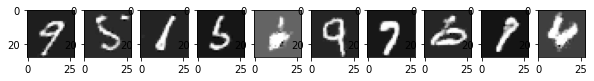

EPOCH : 92 GLOSS: 6.067061424255371 DLOSS: 1.4034781455993652
EPOCH : 93 GLOSS: 7.023324012756348 DLOSS: 1.3415136337280273
EPOCH : 94 GLOSS: 6.03228759765625 DLOSS: 1.3870151042938232
EPOCH : 95 GLOSS: 5.321050643920898 DLOSS: 1.4153794050216675
EPOCH : 96 GLOSS: 7.161871910095215 DLOSS: 1.3263962268829346
EPOCH : 97 GLOSS: 7.243852138519287 DLOSS: 1.3926348686218262
EPOCH : 98 GLOSS: 7.542781829833984 DLOSS: 1.3800474405288696
EPOCH : 99 GLOSS: 6.427212238311768 DLOSS: 1.3946466445922852
EPOCH : 100 GLOSS: 6.626278400421143 DLOSS: 1.3307647705078125
EPOCH : 101 GLOSS: 5.443234920501709 DLOSS: 1.3684823513031006


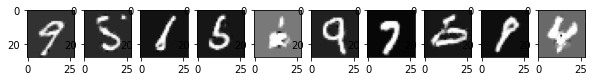

EPOCH : 102 GLOSS: 4.908220291137695 DLOSS: 1.4194188117980957
EPOCH : 103 GLOSS: 6.765342712402344 DLOSS: 1.3768501281738281
EPOCH : 104 GLOSS: 6.202861785888672 DLOSS: 1.399867057800293
EPOCH : 105 GLOSS: 7.470162391662598 DLOSS: 1.3824748992919922
EPOCH : 106 GLOSS: 2.90635347366333 DLOSS: 1.9685723781585693
EPOCH : 107 GLOSS: 5.2802934646606445 DLOSS: 1.4248991012573242
EPOCH : 108 GLOSS: 7.566189289093018 DLOSS: 1.376937985420227
EPOCH : 109 GLOSS: 7.35163688659668 DLOSS: 1.3481225967407227
EPOCH : 110 GLOSS: 5.921799659729004 DLOSS: 1.375024676322937
EPOCH : 111 GLOSS: 5.165034770965576 DLOSS: 1.3701868057250977


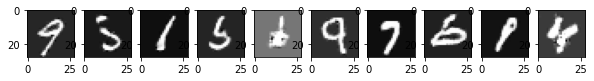

EPOCH : 112 GLOSS: 6.288897514343262 DLOSS: 1.3775192499160767
EPOCH : 113 GLOSS: 4.372138023376465 DLOSS: 1.454453468322754
EPOCH : 114 GLOSS: 6.043240547180176 DLOSS: 1.3546173572540283
EPOCH : 115 GLOSS: 6.554300785064697 DLOSS: 1.392742395401001
EPOCH : 116 GLOSS: 6.0817108154296875 DLOSS: 1.406001329421997
EPOCH : 117 GLOSS: 6.503241062164307 DLOSS: 1.350480318069458
EPOCH : 118 GLOSS: 8.228719711303711 DLOSS: 1.3784706592559814
EPOCH : 119 GLOSS: 5.890573024749756 DLOSS: 1.3562959432601929
EPOCH : 120 GLOSS: 5.496807098388672 DLOSS: 1.4665594100952148
EPOCH : 121 GLOSS: 5.585033893585205 DLOSS: 1.3598092794418335


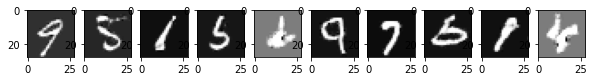

EPOCH : 122 GLOSS: 5.46901798248291 DLOSS: 1.3632019758224487
EPOCH : 123 GLOSS: 10.005267143249512 DLOSS: 1.421436071395874
EPOCH : 124 GLOSS: 8.096668243408203 DLOSS: 1.3409069776535034
EPOCH : 125 GLOSS: 5.993136405944824 DLOSS: 1.3851940631866455
EPOCH : 126 GLOSS: 4.4306745529174805 DLOSS: 1.4027869701385498
EPOCH : 127 GLOSS: 5.353616714477539 DLOSS: 1.37229585647583
EPOCH : 128 GLOSS: 2.8077993392944336 DLOSS: 1.710334062576294
EPOCH : 129 GLOSS: 7.812643051147461 DLOSS: 1.3823879957199097
EPOCH : 130 GLOSS: 5.481809616088867 DLOSS: 1.3401418924331665
EPOCH : 131 GLOSS: 5.867733478546143 DLOSS: 1.3506032228469849


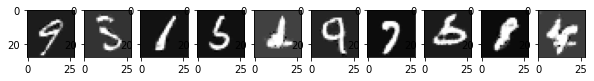

EPOCH : 132 GLOSS: 4.541200637817383 DLOSS: 1.4441674947738647
EPOCH : 133 GLOSS: 4.444036960601807 DLOSS: 1.525882363319397
EPOCH : 134 GLOSS: 6.4412994384765625 DLOSS: 1.4043539762496948
EPOCH : 135 GLOSS: 5.54223108291626 DLOSS: 1.4120668172836304
EPOCH : 136 GLOSS: 5.0088958740234375 DLOSS: 1.375877857208252
EPOCH : 137 GLOSS: 3.6938648223876953 DLOSS: 1.5199567079544067
EPOCH : 138 GLOSS: 6.725623607635498 DLOSS: 1.3930484056472778
EPOCH : 139 GLOSS: 14.758861541748047 DLOSS: 1.4022914171218872
EPOCH : 140 GLOSS: 4.5579071044921875 DLOSS: 1.3955357074737549
EPOCH : 141 GLOSS: 6.845035552978516 DLOSS: 1.345665454864502


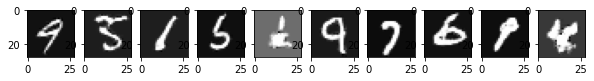

EPOCH : 142 GLOSS: 5.099431037902832 DLOSS: 1.3697078227996826
EPOCH : 143 GLOSS: 4.995523929595947 DLOSS: 1.383928894996643
EPOCH : 144 GLOSS: 7.579925537109375 DLOSS: 1.36756432056427
EPOCH : 145 GLOSS: 8.360956192016602 DLOSS: 1.347976803779602
EPOCH : 146 GLOSS: 3.6709392070770264 DLOSS: 1.6558505296707153
EPOCH : 147 GLOSS: 3.9679651260375977 DLOSS: 1.4708435535430908
EPOCH : 148 GLOSS: 4.3663458824157715 DLOSS: 1.3794467449188232
EPOCH : 149 GLOSS: 5.702611923217773 DLOSS: 1.4346115589141846
EPOCH : 150 GLOSS: 5.852685928344727 DLOSS: 1.4349874258041382
EPOCH : 151 GLOSS: 6.910421848297119 DLOSS: 1.4131178855895996


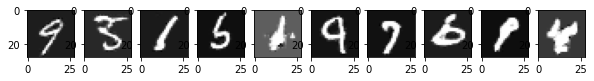

EPOCH : 152 GLOSS: 4.958479881286621 DLOSS: 1.3591463565826416
EPOCH : 153 GLOSS: 5.547535419464111 DLOSS: 1.6652107238769531
EPOCH : 154 GLOSS: 3.7680249214172363 DLOSS: 1.763993501663208
EPOCH : 155 GLOSS: 5.835209846496582 DLOSS: 1.3893404006958008
EPOCH : 156 GLOSS: 4.018780708312988 DLOSS: 1.4487254619598389
EPOCH : 157 GLOSS: 5.15339994430542 DLOSS: 1.4000275135040283
EPOCH : 158 GLOSS: 68.31275939941406 DLOSS: 1.5032691955566406
EPOCH : 159 GLOSS: 5.315604209899902 DLOSS: 1.3845465183258057
EPOCH : 160 GLOSS: 4.494480133056641 DLOSS: 1.3724908828735352
EPOCH : 161 GLOSS: 7.417454719543457 DLOSS: 1.4172780513763428


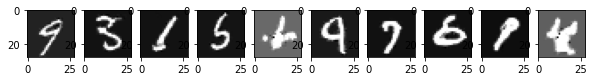

EPOCH : 162 GLOSS: 5.756942272186279 DLOSS: 1.4169843196868896
EPOCH : 163 GLOSS: 3.2215933799743652 DLOSS: 1.8710362911224365
EPOCH : 164 GLOSS: 8.441442489624023 DLOSS: 1.344617486000061
EPOCH : 165 GLOSS: 5.803630828857422 DLOSS: 1.391039490699768
EPOCH : 166 GLOSS: 3.986205816268921 DLOSS: 1.6504671573638916
EPOCH : 167 GLOSS: 8.181619644165039 DLOSS: 2.2303175926208496
EPOCH : 168 GLOSS: 5.483694076538086 DLOSS: 1.3958191871643066
EPOCH : 169 GLOSS: 6.53809118270874 DLOSS: 1.414341926574707
EPOCH : 170 GLOSS: 5.867153167724609 DLOSS: 1.4466629028320312
EPOCH : 171 GLOSS: 5.047272205352783 DLOSS: 1.3960798978805542


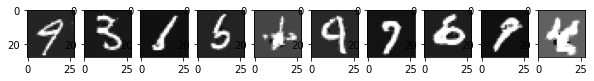

EPOCH : 172 GLOSS: 6.149169445037842 DLOSS: 1.3497695922851562
EPOCH : 173 GLOSS: 5.071761131286621 DLOSS: 1.487433910369873
EPOCH : 174 GLOSS: 5.069762229919434 DLOSS: 1.377531886100769
EPOCH : 175 GLOSS: 7.564360618591309 DLOSS: 1.4974067211151123
EPOCH : 176 GLOSS: 4.967048645019531 DLOSS: 1.424200177192688
EPOCH : 177 GLOSS: 4.886831760406494 DLOSS: 1.4351632595062256
EPOCH : 178 GLOSS: 5.343242645263672 DLOSS: 1.3184953927993774
EPOCH : 179 GLOSS: 8.607361793518066 DLOSS: 1.501797080039978
EPOCH : 180 GLOSS: 4.75192928314209 DLOSS: 1.3772419691085815
EPOCH : 181 GLOSS: 8.74655818939209 DLOSS: 1.6350330114364624


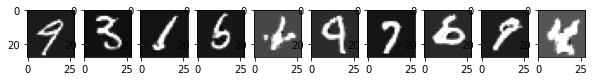

EPOCH : 182 GLOSS: 8.006144523620605 DLOSS: 1.5373198986053467
EPOCH : 183 GLOSS: 7.769179344177246 DLOSS: 1.3920927047729492
EPOCH : 184 GLOSS: 7.111167907714844 DLOSS: 1.379103422164917
EPOCH : 185 GLOSS: 4.681768417358398 DLOSS: 1.639339804649353
EPOCH : 186 GLOSS: 5.766390323638916 DLOSS: 1.4387502670288086
EPOCH : 187 GLOSS: 9.862265586853027 DLOSS: 1.3677290678024292
EPOCH : 188 GLOSS: 8.896657943725586 DLOSS: 1.3773424625396729
EPOCH : 189 GLOSS: 7.191892623901367 DLOSS: 1.3335859775543213
EPOCH : 190 GLOSS: 7.594109535217285 DLOSS: 1.445767879486084
EPOCH : 191 GLOSS: 8.58797836303711 DLOSS: 1.4486613273620605


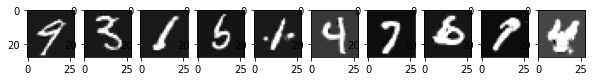

EPOCH : 192 GLOSS: 6.018094539642334 DLOSS: 1.363445520401001
EPOCH : 193 GLOSS: 6.15551233291626 DLOSS: 1.3554317951202393
EPOCH : 194 GLOSS: 6.350450038909912 DLOSS: 1.4749064445495605
EPOCH : 195 GLOSS: 5.735266208648682 DLOSS: 1.460092544555664
EPOCH : 196 GLOSS: 8.910724639892578 DLOSS: 1.6179382801055908
EPOCH : 197 GLOSS: 5.214094638824463 DLOSS: 1.4034245014190674
EPOCH : 198 GLOSS: 4.727066516876221 DLOSS: 1.5118216276168823
EPOCH : 199 GLOSS: 6.8758463859558105 DLOSS: 1.4232523441314697
EPOCH : 200 GLOSS: 5.318915367126465 DLOSS: 1.427626371383667
EPOCH : 201 GLOSS: 6.1364850997924805 DLOSS: 1.391220211982727


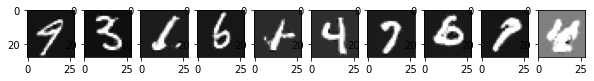

EPOCH : 202 GLOSS: 8.023560523986816 DLOSS: 1.8341343402862549
EPOCH : 203 GLOSS: 7.037756443023682 DLOSS: 1.4061616659164429
EPOCH : 204 GLOSS: 5.284320831298828 DLOSS: 1.3594216108322144
EPOCH : 205 GLOSS: 4.628594875335693 DLOSS: 1.3607386350631714
EPOCH : 206 GLOSS: 6.638617992401123 DLOSS: 1.416854739189148
EPOCH : 207 GLOSS: 5.2094807624816895 DLOSS: 1.4551987648010254
EPOCH : 208 GLOSS: 9.133299827575684 DLOSS: 1.3868680000305176
EPOCH : 209 GLOSS: 6.9177045822143555 DLOSS: 1.3957529067993164
EPOCH : 210 GLOSS: 4.696391582489014 DLOSS: 1.3743631839752197
EPOCH : 211 GLOSS: 8.001249313354492 DLOSS: 1.5255417823791504


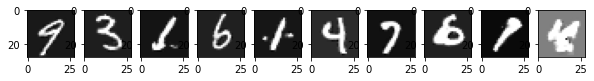

EPOCH : 212 GLOSS: 6.711114883422852 DLOSS: 1.4158496856689453
EPOCH : 213 GLOSS: 7.509739398956299 DLOSS: 1.3330851793289185
EPOCH : 214 GLOSS: 7.821079254150391 DLOSS: 1.435926914215088
EPOCH : 215 GLOSS: 6.759775161743164 DLOSS: 1.3683867454528809
EPOCH : 216 GLOSS: 6.866024017333984 DLOSS: 1.3892691135406494
EPOCH : 217 GLOSS: 5.205623626708984 DLOSS: 1.4549007415771484
EPOCH : 218 GLOSS: 50.620052337646484 DLOSS: 1.4197850227355957
EPOCH : 219 GLOSS: 7.310073375701904 DLOSS: 1.4147123098373413
EPOCH : 220 GLOSS: 6.228932857513428 DLOSS: 1.3951550722122192
EPOCH : 221 GLOSS: 8.536222457885742 DLOSS: 1.3970098495483398


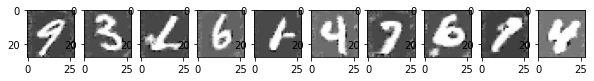

EPOCH : 222 GLOSS: 6.285690784454346 DLOSS: 1.3971142768859863
EPOCH : 223 GLOSS: 4.972224235534668 DLOSS: 1.3511526584625244
EPOCH : 224 GLOSS: 9.973397254943848 DLOSS: 1.334223985671997
EPOCH : 225 GLOSS: 9.474122047424316 DLOSS: 1.3741023540496826
EPOCH : 226 GLOSS: 5.601362228393555 DLOSS: 1.4233812093734741
EPOCH : 227 GLOSS: 5.8094587326049805 DLOSS: 1.4250853061676025
EPOCH : 228 GLOSS: 5.443840503692627 DLOSS: 1.3625065088272095
EPOCH : 229 GLOSS: 9.800129890441895 DLOSS: 1.4098727703094482
EPOCH : 230 GLOSS: 4.342844009399414 DLOSS: 1.417712926864624
EPOCH : 231 GLOSS: 6.6710429191589355 DLOSS: 1.3846462965011597


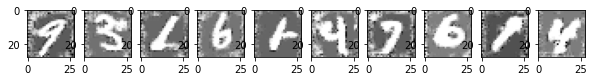

EPOCH : 232 GLOSS: 7.0064496994018555 DLOSS: 1.4356588125228882
EPOCH : 233 GLOSS: 9.344980239868164 DLOSS: 1.9396440982818604
EPOCH : 234 GLOSS: 5.966512680053711 DLOSS: 1.3232258558273315
EPOCH : 235 GLOSS: 12.238752365112305 DLOSS: 1.3470864295959473
EPOCH : 236 GLOSS: 4.431097030639648 DLOSS: 1.5361745357513428
EPOCH : 237 GLOSS: 5.688097953796387 DLOSS: 1.4077483415603638
EPOCH : 238 GLOSS: 5.257853031158447 DLOSS: 1.364530324935913
EPOCH : 239 GLOSS: 4.46640157699585 DLOSS: 1.402113676071167
EPOCH : 240 GLOSS: 5.9923095703125 DLOSS: 1.5547937154769897
EPOCH : 241 GLOSS: 6.745687961578369 DLOSS: 1.8987985849380493


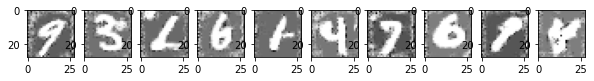

EPOCH : 242 GLOSS: 8.87306022644043 DLOSS: 1.4223743677139282
EPOCH : 243 GLOSS: 9.416080474853516 DLOSS: 1.4223997592926025
EPOCH : 244 GLOSS: 5.990318775177002 DLOSS: 1.4684584140777588
EPOCH : 245 GLOSS: 9.187810897827148 DLOSS: 1.3369985818862915
EPOCH : 246 GLOSS: 6.383503437042236 DLOSS: 1.3663837909698486
EPOCH : 247 GLOSS: 3.902194023132324 DLOSS: 1.9103810787200928
EPOCH : 248 GLOSS: 4.737434387207031 DLOSS: 1.3672878742218018
EPOCH : 249 GLOSS: 6.3364691734313965 DLOSS: 1.3398274183273315
EPOCH : 250 GLOSS: 8.522221565246582 DLOSS: 1.4110078811645508
EPOCH : 251 GLOSS: 7.761912822723389 DLOSS: 1.4415278434753418


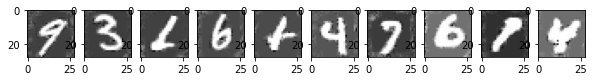

EPOCH : 252 GLOSS: 8.133505821228027 DLOSS: 1.3765393495559692
EPOCH : 253 GLOSS: 4.957117557525635 DLOSS: 1.6334787607192993
EPOCH : 254 GLOSS: 6.152215957641602 DLOSS: 1.3710026741027832
EPOCH : 255 GLOSS: 11.944046020507812 DLOSS: 1.3719676733016968
EPOCH : 256 GLOSS: 10.372865676879883 DLOSS: 1.3762619495391846
EPOCH : 257 GLOSS: 7.50071382522583 DLOSS: 1.389455795288086
EPOCH : 258 GLOSS: 6.027228355407715 DLOSS: 1.4896440505981445
EPOCH : 259 GLOSS: 7.399164199829102 DLOSS: 1.3205358982086182
EPOCH : 260 GLOSS: 10.916080474853516 DLOSS: 1.3970831632614136
EPOCH : 261 GLOSS: 4.452293395996094 DLOSS: 1.7265183925628662


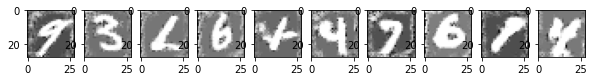

EPOCH : 262 GLOSS: 8.332046508789062 DLOSS: 1.5824611186981201
EPOCH : 263 GLOSS: 7.7541823387146 DLOSS: 1.3277981281280518
EPOCH : 264 GLOSS: 5.6025710105896 DLOSS: 1.3666138648986816
EPOCH : 265 GLOSS: 9.380818367004395 DLOSS: 1.3294923305511475
EPOCH : 266 GLOSS: 7.401387691497803 DLOSS: 1.2959390878677368
EPOCH : 267 GLOSS: 45.1976318359375 DLOSS: 1.442949652671814
EPOCH : 268 GLOSS: 6.005704879760742 DLOSS: 1.3643275499343872
EPOCH : 269 GLOSS: 5.228870868682861 DLOSS: 1.4401311874389648
EPOCH : 270 GLOSS: 6.806049346923828 DLOSS: 1.3219690322875977
EPOCH : 271 GLOSS: 5.608214855194092 DLOSS: 1.327457308769226


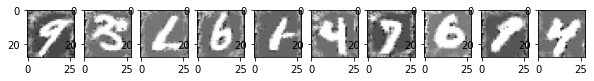

EPOCH : 272 GLOSS: 3.8645782470703125 DLOSS: 1.965029239654541
EPOCH : 273 GLOSS: 10.500166893005371 DLOSS: 1.362525224685669
EPOCH : 274 GLOSS: 7.520293235778809 DLOSS: 1.2941703796386719
EPOCH : 275 GLOSS: 4.349543571472168 DLOSS: 1.3761112689971924
EPOCH : 276 GLOSS: 6.583273410797119 DLOSS: 1.340771198272705
EPOCH : 277 GLOSS: 6.464207172393799 DLOSS: 1.3451002836227417
EPOCH : 278 GLOSS: 7.015254974365234 DLOSS: 1.4036657810211182
EPOCH : 279 GLOSS: 7.682818412780762 DLOSS: 1.4443567991256714
EPOCH : 280 GLOSS: 21.101118087768555 DLOSS: 1.3853896856307983
EPOCH : 281 GLOSS: 6.11741828918457 DLOSS: 1.6083060503005981


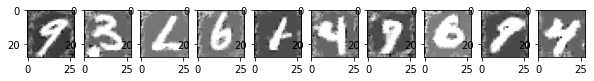

EPOCH : 282 GLOSS: 6.123274803161621 DLOSS: 1.377894401550293
EPOCH : 283 GLOSS: 7.715169429779053 DLOSS: 1.3337173461914062
EPOCH : 284 GLOSS: 7.526808738708496 DLOSS: 1.337470293045044
EPOCH : 285 GLOSS: 9.157310485839844 DLOSS: 1.4009127616882324
EPOCH : 286 GLOSS: 6.3783698081970215 DLOSS: 1.3314857482910156
EPOCH : 287 GLOSS: 8.437580108642578 DLOSS: 1.2739903926849365
EPOCH : 288 GLOSS: 7.878855228424072 DLOSS: 1.3855952024459839
EPOCH : 289 GLOSS: 11.347431182861328 DLOSS: 1.469947099685669
EPOCH : 290 GLOSS: 5.855014324188232 DLOSS: 1.3680405616760254
EPOCH : 291 GLOSS: 5.842719078063965 DLOSS: 1.352459192276001


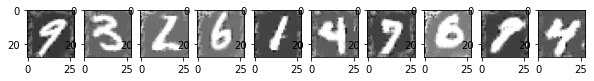

EPOCH : 292 GLOSS: 10.139060020446777 DLOSS: 1.351845622062683
EPOCH : 293 GLOSS: 7.1442484855651855 DLOSS: 1.3635720014572144
EPOCH : 294 GLOSS: 4.724695682525635 DLOSS: 1.5492668151855469
EPOCH : 295 GLOSS: 7.080150604248047 DLOSS: 1.363147497177124
EPOCH : 296 GLOSS: 11.607315063476562 DLOSS: 1.4816977977752686
EPOCH : 297 GLOSS: 7.1863789558410645 DLOSS: 1.293039321899414
EPOCH : 298 GLOSS: 8.296226501464844 DLOSS: 1.2959785461425781
EPOCH : 299 GLOSS: 8.0062894821167 DLOSS: 1.6343450546264648
EPOCH : 300 GLOSS: 9.563896179199219 DLOSS: 1.396192193031311
EPOCH : 301 GLOSS: 16.635637283325195 DLOSS: 1.3187992572784424


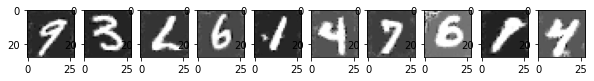

EPOCH : 302 GLOSS: 7.3657732009887695 DLOSS: 1.3136035203933716
EPOCH : 303 GLOSS: 5.56873893737793 DLOSS: 1.324913740158081
EPOCH : 304 GLOSS: 4.419820785522461 DLOSS: 1.3311136960983276
EPOCH : 305 GLOSS: 4.384365558624268 DLOSS: 1.4036391973495483
EPOCH : 306 GLOSS: 6.563494682312012 DLOSS: 1.3023426532745361
EPOCH : 307 GLOSS: 6.357424736022949 DLOSS: 1.3764697313308716
EPOCH : 308 GLOSS: 6.2639923095703125 DLOSS: 1.3203940391540527
EPOCH : 309 GLOSS: 6.593441486358643 DLOSS: 1.331933856010437
EPOCH : 310 GLOSS: 5.175075531005859 DLOSS: 1.4167729616165161
EPOCH : 311 GLOSS: 5.416443347930908 DLOSS: 1.3845314979553223


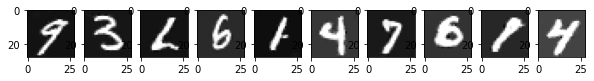

EPOCH : 312 GLOSS: 3.0927209854125977 DLOSS: 1.583611249923706
EPOCH : 313 GLOSS: 6.494719505310059 DLOSS: 1.4934844970703125
EPOCH : 314 GLOSS: 7.024324893951416 DLOSS: 1.5064139366149902
EPOCH : 315 GLOSS: 5.566830635070801 DLOSS: 1.572048544883728
EPOCH : 316 GLOSS: 5.397409915924072 DLOSS: 1.3865206241607666
EPOCH : 317 GLOSS: 4.35172700881958 DLOSS: 1.7752019166946411
EPOCH : 318 GLOSS: 5.145112037658691 DLOSS: 1.4181559085845947
EPOCH : 319 GLOSS: 4.290012359619141 DLOSS: 1.4546236991882324
EPOCH : 320 GLOSS: 7.085925102233887 DLOSS: 1.517735481262207
EPOCH : 321 GLOSS: 6.104568958282471 DLOSS: 1.3924682140350342


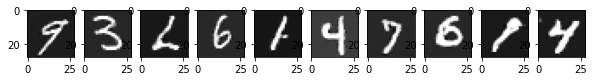

EPOCH : 322 GLOSS: 4.103602409362793 DLOSS: 1.668177604675293
EPOCH : 323 GLOSS: 4.933468818664551 DLOSS: 1.4791464805603027
EPOCH : 324 GLOSS: 4.438466548919678 DLOSS: 1.4823458194732666
EPOCH : 325 GLOSS: 6.834380626678467 DLOSS: 1.468747854232788
EPOCH : 326 GLOSS: 5.067427635192871 DLOSS: 1.3997955322265625
EPOCH : 327 GLOSS: 4.266609191894531 DLOSS: 1.526254653930664
EPOCH : 328 GLOSS: 8.858531951904297 DLOSS: 1.4201993942260742
EPOCH : 329 GLOSS: 4.852297782897949 DLOSS: 1.5516157150268555
EPOCH : 330 GLOSS: 4.861762046813965 DLOSS: 1.4684053659439087
EPOCH : 331 GLOSS: 4.717622756958008 DLOSS: 1.4486207962036133


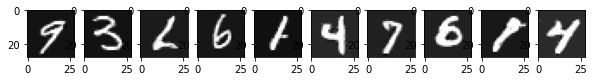

EPOCH : 332 GLOSS: 6.883949279785156 DLOSS: 1.3605973720550537
EPOCH : 333 GLOSS: 4.758764266967773 DLOSS: 1.418367862701416
EPOCH : 334 GLOSS: 5.7852935791015625 DLOSS: 1.4107184410095215
EPOCH : 335 GLOSS: 5.315115451812744 DLOSS: 1.5352814197540283
EPOCH : 336 GLOSS: 4.121184349060059 DLOSS: 1.4950909614562988
EPOCH : 337 GLOSS: 5.763912200927734 DLOSS: 1.4587376117706299
EPOCH : 338 GLOSS: 5.276077747344971 DLOSS: 1.720758080482483
EPOCH : 339 GLOSS: 5.380692958831787 DLOSS: 1.4700782299041748
EPOCH : 340 GLOSS: 6.150932312011719 DLOSS: 1.48578941822052
EPOCH : 341 GLOSS: 5.978599548339844 DLOSS: 1.4133257865905762


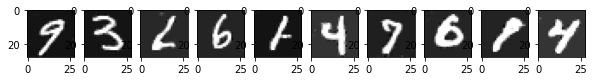

EPOCH : 342 GLOSS: 6.937065124511719 DLOSS: 1.4539910554885864
EPOCH : 343 GLOSS: 6.987479209899902 DLOSS: 1.397040605545044
EPOCH : 344 GLOSS: 4.937189102172852 DLOSS: 1.3886232376098633
EPOCH : 345 GLOSS: 4.724854946136475 DLOSS: 1.4412686824798584
EPOCH : 346 GLOSS: 4.566680908203125 DLOSS: 1.4344379901885986
EPOCH : 347 GLOSS: 5.361238479614258 DLOSS: 1.5740455389022827
EPOCH : 348 GLOSS: 6.944814205169678 DLOSS: 1.3954482078552246
EPOCH : 349 GLOSS: 4.612076759338379 DLOSS: 1.5672141313552856
EPOCH : 350 GLOSS: 6.771573543548584 DLOSS: 1.5246102809906006
EPOCH : 351 GLOSS: 5.917485237121582 DLOSS: 1.392830729484558


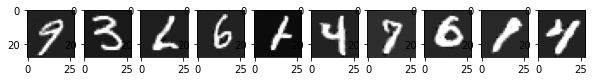

EPOCH : 352 GLOSS: 5.6533637046813965 DLOSS: 1.3817155361175537


KeyboardInterrupt: ignored

In [ ]:


for i in range(epoch):
    for real_images in real_images_arr:

        cont_noise = generate_cont(batch_size, cont_dim)
        dist_noise = generate_dist(generate_dist_vector(batch_size, dist_dim), dist_dim)
        
        random_noises = torch.cat([cont_noise, dist_noise, generate_noise(batch_size, noise_dim)], dim=1)
        fake_images = G(random_noises)
        real_outs = D(real_images)
        fake_outs = D(fake_images)

        fake_out_cc = fake_outs[:, 1:1 + cont_dim]
        fake_out_dc = fake_outs[:, 1 + cont_dim:]
        
        D_loss = criterion(real_outs[:, 0], real_labels) + \
            criterion(fake_outs[:, 0], fake_labels) + c_weight * crit_dist(fake_out_dc, dist_noise.view(batch_size, -1)) + \
            c_weight * torch.mean((fake_out_cc - cont_noise) * (fake_out_cc - cont_noise))
        
        D_optim.zero_grad()
        G_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        fake_images = G(random_noises)
        fake_outs = D(fake_images)
        fake_out_cc = fake_outs[:, 1:1 + cont_dim]
        fake_out_dc = fake_outs[:, 1 + cont_dim:]

        
        G_loss = criterion(fake_outs[:, 0], real_labels) + c_weight * crit_dist(fake_out_dc, dist_noise.view(batch_size, -1)) +\
            c_weight * torch.mean((fake_out_cc - cont_noise) * (fake_out_cc - cont_noise))

        D_optim.zero_grad()
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

    print("EPOCH :", i + 1, "GLOSS:", G_loss.item(), "DLOSS:", D_loss.item())

    if i % print_per == 0:
        generated_images = G(noise_for_print).view(test_len, 28, 28)
        plt.figure(figsize = (10, 100))
        for j in range(test_len):
            plt.subplot(1, test_len, j + 1)
            idx = idx + 1
            plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
        plt.show()

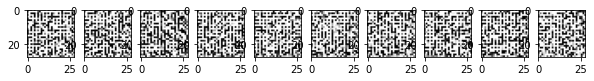

In [19]:
orig_cont_noise = generate_cont(1, cont_dim).expand(test_len, cont_dim, 1, 1)
cont_noise = orig_cont_noise.clone()
dist_noise = generate_dist(torch.arange(test_len), dist_dim)
noise_for_print = torch.cat([cont_noise, dist_noise, generate_noise(test_len, noise_dim)], dim=1)

generated_images = G(noise_for_print).view(test_len, 28, 28)
plt.figure(figsize = (10, 100))
for j in range(test_len):
    plt.subplot(1, test_len, j + 1)
    idx = idx + 1
    plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
plt.show()

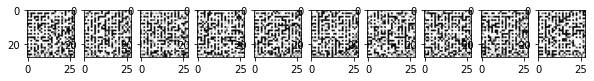

In [17]:
cont_noise = orig_cont_noise.clone()
cont_noise[:,0,:,:] = torch.arange(test_len).view(-1, 1, 1)/10
dist_noise = generate_dist(torch.zeros(test_len).long(), dist_dim)
noise_for_print = torch.cat([cont_noise, dist_noise, generate_noise(test_len, noise_dim)], dim=1)

generated_images = G(noise_for_print).view(test_len, 28, 28)
plt.figure(figsize = (10, 100))
for j in range(test_len):
    plt.subplot(1, test_len, j + 1)
    idx = idx + 1
    plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
plt.show()

In [ ]:
cont_noise = orig_cont_noise.clone()
cont_noise[:,1,:,:] = torch.arange(test_len).view(-1, 1, 1)/10
noise_for_print = torch.cat([cont_noise, dist_noise, generate_noise(test_len, noise_dim)], dim=1)

generated_images = G(noise_for_print).view(test_len, 28, 28)
plt.figure(figsize = (10, 100))
for j in range(test_len):
    plt.subplot(1, test_len, j + 1)
    idx = idx + 1
    plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
plt.show()

In [ ]:
cont_noise = orig_cont_noise.clone()
cont_noise[:,2,:,:] = torch.arange(test_len).view(-1, 1, 1)/10
noise_for_print = torch.cat([cont_noise, dist_noise, generate_noise(test_len, noise_dim)], dim=1)

generated_images = G(noise_for_print).view(test_len, 28, 28)
plt.figure(figsize = (10, 100))
for j in range(test_len):
    plt.subplot(1, test_len, j + 1)
    idx = idx + 1
    plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
plt.show()

In [ ]:
cont_noise = orig_cont_noise.clone()
cont_noise[:,3,:,:] = torch.arange(test_len).view(-1, 1, 1)/10
noise_for_print = torch.cat([cont_noise, dist_noise, generate_noise(test_len, noise_dim)], dim=1)

generated_images = G(noise_for_print).view(test_len, 28, 28)
plt.figure(figsize = (10, 100))
for j in range(test_len):
    plt.subplot(1, test_len, j + 1)
    idx = idx + 1
    plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
plt.show()